# Быстрое определение писателя по цитате из его произведения с помощью нейросетей. Описание проекта.

У нас есть датасет, в котором представлены трое авторов: Эдгара Алан По (EAP в данных), Говард Филлипс Лавкравт (HPL) и Мэри Шелли (MWS), а так же цитата из их произведений. В рамках этого проекта мы попробуем с помощью библиотеки Keras создать модель, которая будет верно определять автора по цитате из его произведения.

Оценивать работу модели будем с помощью метрики Accuracy.

#Загрузка необходимых биболиотек, данных, их изучение.

Загружаем необходимые для решения задачи библиотеки.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Фиксируем все возможные случайные значения  для воспроизводимости кода.

In [2]:
RNDM_STATE = 4
np.random.seed(RNDM_STATE)
random.seed(RNDM_STATE)
tf.random.set_seed(RNDM_STATE)

Загружаем данные.

In [3]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Spooky_writers/train.csv')
df

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


Смотрим информацию о них.

In [4]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


Пропусков в данных нет.

Посмотрим, сколько записей по каждому из рассматриваемых авторов представлено в нашем датасете.

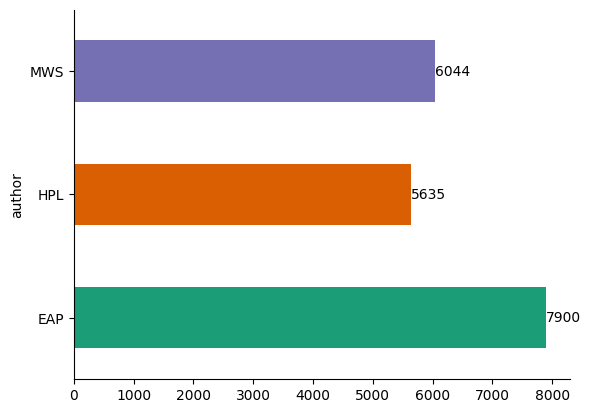

In [5]:
counts = df.groupby('author').size()

ax = counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + i.get_height()/2,
            str(int(i.get_width())),
            va='center')

plt.show()

В данных есть перекос по количеству строк в сторону Эдгара По. Эти пропорции классов мы обязательно учтём чуть позже.

# Подготовка данных.
Создаём списки с текстами и авторами.

In [6]:
texts = df['text'].values
authors = df['author'].values

print(texts)
print(authors)

['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'
 'It never once occurred to me that the fumbling might be a mere mistake.'
 'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'
 ...
 'Mais il faut agir that is to say, a Frenchman never faints outright.'
 'For an item of news like this, it strikes us it was very coolly received."'
 'He laid a gnarled claw on my shoulder, and it seemed to me that its shaking was not altogether that of mirth.']
['EAP' 'HPL' 'EAP' ... 'EAP' 'EAP' 'HPL']


Выполняем кодирование меток авторов.

In [7]:
label_encoder = LabelEncoder()
encoded_authors = label_encoder.fit_transform(authors)
num_classes = len(np.unique(encoded_authors))

 Разбиваем данные на тренировочную и тестовую выборки с учётом пропорций классов.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    encoded_authors,
    test_size=0.2,
    random_state=RNDM_STATE,
    stratify=encoded_authors)

Делаем подготовку последовательностей текста для будущей модели.

In [9]:
max_words = 1000  # Максимальное количество слов в тексте
max_len = 100  # Максимальная длина последовательности

Токенизируем тексты.

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

Преобразуем метки в категориальный формат.

In [11]:
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Создание и обучение модели.


Создаём модель LSTM.

In [12]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Оучаем модель, не забыв включить ранню остановку, считаем значение метрики на тестовой выборке, предсказание модели сохраняем в переменную для дальнейшего построения матрицы ошибок.

In [13]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stopping],
)

loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Значение метрики accuracy на тестовой выборке: {accuracy:.4f}")

y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5507 - loss: 0.9086 - val_accuracy: 0.7362 - val_loss: 0.6431
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7474 - loss: 0.6054 - val_accuracy: 0.7339 - val_loss: 0.6440
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7650 - loss: 0.5670 - val_accuracy: 0.7296 - val_loss: 0.6496
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7726 - loss: 0.5371 - val_accuracy: 0.7293 - val_loss: 0.6546
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7886 - loss: 0.5084 - val_accuracy: 0.7229 - val_loss: 0.6702
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7978 - loss: 0.4893 - val_accuracy: 0.7191 - val_loss: 0.7054
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7260 - loss: 0.6627
Значение метрики accuracy на тестовой выборке: 0.7362
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Итак, мы получили значение метрики 0.7362. Теперь по матрице ошибок посмотрим, с каким именно количеством ошибок наша модель определяла каждого из писателей.

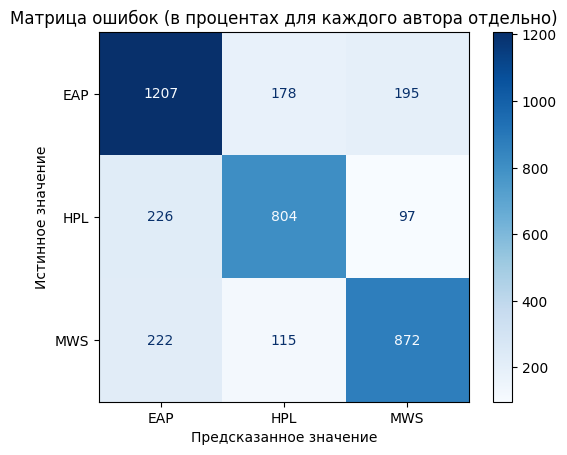

In [14]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок (в процентах для каждого автора отдельно)')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказанное значение')
plt.show()

По был верно распознан в 76% случаев, Лавкрафт - в 71%, Шелли - в 72%.

# Выводы.                 
С помощью нейронной сети нам удалось быстро и без лишней работы с данными получить значение метрики accuracy 0.7362. Лучше всех моделью был распознан Эдгар По, что может быть связано с тем, что в исходном датасете приведено больше всего образцов именно из его текстов. Для дальнейшего улучшения результатов можно предложить увеличение обрабатываемых данных, а именно цитат из произведений Лавкрафта и Шелли, более тонкую настройку данной нейросети, попргобовать обработать эти данные другой нейросетью.

Подобный подход к обработке текстов известных писателей при должной точности может быть примененён в книжных сервисах и риложениях-энциклопедиях для проверки авторов цитат, а также для улучшения функций поисковиков (поиск автора книги по неточной цитате из его произведения).